# Description

This notebook compares the batting average race between Don Mattingly and Wade Boggs during the 1986 MLB season.

## Requirements

A Retrosheet database ([instructions](https://gitlab.com/jasonmm/how-to/blob/master/create/retrosheet-database.md)).

An evironment variable named "DB_CONN" that contains the database connection string in the form of "&lt;driver>://&lt;username>:&lt;password>@&lt;hostname>:&lt;port>/&lt;database_name>" for connecting to the Retrosheet database.

# Setup

In [1]:
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

db_engine = create_engine(os.environ['DB_CONN'])

%load_ext sql_magic

%config SQL.conn_name = 'db_engine'
%config SQL.notify_result = False
%config SQL.output_result = False

%matplotlib inline

# Functions

These are the functions used to retrieve data and process the DataFrames.

In [2]:
def get_retrosheet_data(player_id, year):
    """Runs the SQL to get the player's events in the given year.
    The `%read_sql` magic must be assigned to a variable and cannot 
    be returned directly without triggering a syntax error. The SQL
    must also be all on one line."""
    r = %read_sql SELECT GAME_ID, BAT_ID, INN_CT, OUTS_CT, EVENT_TX, EVENT_CD, BAT_EVENT_FL, AB_FL FROM events WHERE BAT_ID="{player_id}" AND YearId={year} AND BAT_EVENT_FL="T" ORDER BY SUBSTRING(GAME_ID, -9), INN_CT, OUTS_CT;
    return r

In [3]:
def convert_tf(df, column_names):
    """Converts DataFrame columns that use 'T' and 'F' as booleans into integers 1 and 0."""
    for name in column_names:
        df[name] = df[name].map({'T': 1, 'F': 0})
    return df

In [4]:
# This cell contains functions and data used to set the outcome columns
hit_letters = ['S', 'D', 'T', 'H']
safety_letters = hit_letters + ['W']

def is_out(ch):
    return ch not in safety_letters

def is_hit(ch):
    return ch in hit_letters

def is_single(ch):
    return ch == 'S'

def is_double(ch):
    return ch == 'D'

def is_triple(ch):
    return ch == 'T'

def is_homerun(ch):
    return ch == 'H'

def is_walk(ch):
    return ch == 'W'

In [5]:
def add_outcome_columns(df):
    """An "outcome column" is a column in the DataFrame that tells the outcome 
    of the plate appearance. These columns are boolean columns telling whether 
    the outcome described by the column's name happened or whether it did not 
    happen. For example, if `hit?` is false then the plate appearance did not 
    result in a hit."""
    df['game_id'] = df['GAME_ID'].map(lambda x: x[3:])
    df['char'] = df['EVENT_TX'].map(lambda x: x[0])
    df['out?'] = df['char'].map(lambda c: is_out(c))
    df['hit?'] = df['char'].map(lambda c: is_hit(c))
    df['single?'] = df['char'].map(lambda c: is_single(c))
    df['double?'] = df['char'].map(lambda c: is_double(c))
    df['triple?'] = df['char'].map(lambda c: is_triple(c))
    df['homerun?'] = df['char'].map(lambda c: is_homerun(c))
    df['walk?'] = df['char'].map(lambda c: is_walk(c))
    return df.drop(['char'], axis=1)

In [6]:
def drop_before_group(df):
    """Cleans up the DataFrame before grouping."""
    return df.drop(['GAME_ID', 'BAT_ID', 'EVENT_TX', 'EVENT_CD', 'INN_CT', 'OUTS_CT', 'BAT_EVENT_FL', 'AB_FL'], axis=1)

In [7]:
def group_by_game(df):
    """Groups the DataFrame by 'game_id' and creates a new sequentially 
    numbered column called 'game_number'."""
    grouped_df = df.groupby(["game_id"]).sum()
    grouped_df = grouped_df.reset_index()   # https://stackoverflow.com/a/36316186
    grouped_df.insert(0, 'game_number', range(0, len(grouped_df)))
    grouped_df = grouped_df.sort_values('game_id', axis=0)
    return grouped_df

In [8]:
def process(player_id, year, window_size):
    """This poorly named function retrieves the data and returns a 
    DataFrame with the windowed data."""
    df = get_retrosheet_data(player_id, year)
    df = convert_tf(df, ['BAT_EVENT_FL', 'AB_FL'])
    df = add_outcome_columns(df)
    
    # These column names are pluralized here because later they will 
    # store sums and so the pluralized names will be more accurate then.
    df['plateappearances'] = df['BAT_EVENT_FL']
    df['atbats'] = df['AB_FL']

    df = drop_before_group(df)
    grouped_df = group_by_game(df)
    df = grouped_df.rolling(window_size).sum().dropna()
    
    # Make the column names more meaningful.
    df.columns = ['game_number', 'game_id', 'outs', 'hits', 'singles', 'doubles', 'triples', 'homeruns', 'walks', 'pa', 'at_bats']

    min_game_number = grouped_df.rolling(window_size).min().dropna()['game_number']
    max_game_number = grouped_df.rolling(window_size).max().dropna()['game_number']
    
    df_with_avgs = df.assign(bavg=df.hits / df.at_bats) \
                     .assign(oba=(df.hits+df.walks) / (df.at_bats+df.walks)) \
                     .assign(slg=( (df.hits-df.doubles-df.triples-df.homeruns) + (2 * df.doubles) + (3 * df.triples) + (4 * df.homeruns) ) / df.at_bats) \
                     .assign(pa=df.at_bats+df.walks) \
                     .assign(first_game=min_game_number) \
                     .assign(last_game=max_game_number)
    
    return df_with_avgs

In [9]:
def graph(df, title):
    ax = df.plot(x='last_game', y='bavg', kind='line')
    df.plot(x='last_game', y='oba', kind='line', ax=ax, color='C2')
    df.plot(x='last_game', y='slg', kind='line', ax=ax, color='C3')
    ax.set_xlabel('Game Number')
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([0.2, 0.8])
    axes.grid(True)
    return ax

Query started at 07:50:23 AM CST; Query executed in 0.00 m

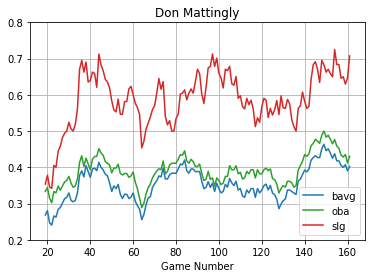

In [10]:
mattingly_df = process('mattd001', 1986, 20)
graph(mattingly_df, 'Don Mattingly')

Query started at 07:50:27 AM CST; Query executed in 0.00 m

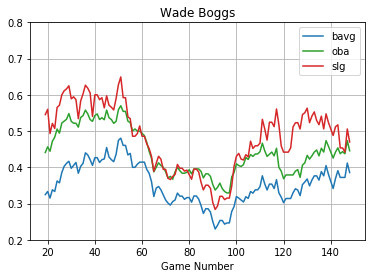

In [11]:
boggs_df = process('boggw001', 1986, 20)
graph(boggs_df, 'Wade Boggs')

# Conclusion

Despite Boggs winning the batting title in 1986 Mattingly was the more desirable offensive player. Mattingly's batting and on-base were more consistent and he hit for considerably more power. 